In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#%config InlineBackend.figure_format = 'svg'
#%config InlineBackend.figure_format = 'pdf'

In [2]:
import kmod
import kmod.glo as glo
import kmod.plot as plot
import kmod.kernel as kernel
from kmod import util
import kmod.ex.exutil as exutil

import matplotlib
import matplotlib.pyplot as plt
import os
import numpy as np
import scipy.stats as stats
import torch
import torch.autograd
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms


from torch import optim
from torch import nn
from kmod.gan_ume_opt import ume_power_criterion

In [3]:
# font options
font = {
    #'family' : 'normal',
    #'weight' : 'bold',
    'size'   : 18
}

plt.rc('font', **font)
plt.rc('lines', linewidth=2)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [4]:
# set this to False to avoid using a GPU
use_cuda = True and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
default_type = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
torch.set_default_tensor_type(torch.cuda.FloatTensor if use_cuda else torch.FloatTensor)

In [5]:
seed = 13
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

# Load feature extractor

In [6]:
# load a model from the shared folder
shared_resource_path = glo.shared_resource_folder()
model_folder = glo.shared_resource_folder('prob_models', 'mnist_cnn')
epochs = 20
seed = 1
model_fname = 'mnist_cnn_ep{}_s{}.pt'.format(epochs, seed)
model_fpath = os.path.join(model_folder, model_fname)

print('Shared resource path at: {}'.format(shared_resource_path))
print('Model folder: {}'.format(model_folder))
print('Model file: ', model_fname)

Shared resource path at: /nfs/data3/heishiro/Gdrive/kmod_share/
Model folder: /nfs/data3/heishiro/Gdrive/kmod_share/prob_models/mnist_cnn
Model file:  mnist_cnn_ep20_s1.pt


In [7]:
from kmod.mnist.classify import MnistClassifier
# load option depends on whether GPU is used
load_options = {} if use_cuda else {'map_location': lambda storage, loc: storage} 
classifier = MnistClassifier.load(model_fpath, **load_options)
# evaluation mode
classifier = classifier.eval().to(device)
# classifier is a torch.nn.Module
display(classifier)

MnistClassifier(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [8]:
def extractor(imgs):
    """
    Feature extractor
    """
    self = classifier
    x = imgs
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = F.relu(F.max_pool2d(self.conv2(x), 2))
    x = x.view(-1, 320)
    return x

def extractor_cls(imgs):
    self = classifier
    x = imgs
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
    x = x.view(-1, 320)
    x = F.relu(self.fc1(x))
    return x

## Load models and generate samples

In [9]:
# these lines are necessary for loading DCGAN
from kmod.mnist.dcgan import Generator
from kmod.mnist.dcgan import DCGAN

In [10]:
model_type_p = 'lsgan'
epoch = 30
gen_p = exutil.load_mnist_gen(model_type_p, epoch, default_type)
model_name_p = '{}_{}'.format(model_type_p, epoch)

Loading  lsgan
Shared resource path at: /nfs/data3/heishiro/Gdrive/kmod_share/
Model folder: /nfs/data3/heishiro/Gdrive/kmod_share/prob_models/mnist_lsgan/30
Model file:  LSGAN_G.pkl


<Figure size 1440x360 with 0 Axes>

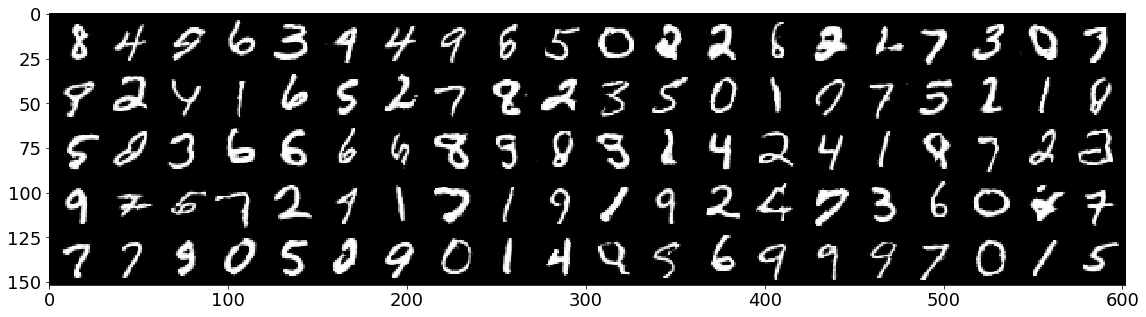

In [11]:
import kmod.plot as plot

# generate images and show
n_gen = 20*5
gen_imgs = gen_p.sample(n_gen)

plt.figure(figsize=(20, 5))
plot.show_torch_imgs(gen_imgs, nrow=20, figsize=(20, 5), normalize=True)

In [12]:
model_type_q = 'dcgan'
epoch = 50
gen_q = exutil.load_mnist_gen(model_type_q, epoch, default_type)
model_name_q = '{}_{}'.format(model_type_q, epoch)

Loading  dcgan
Shared resource path at: /nfs/data3/heishiro/Gdrive/kmod_share/
Model folder: /nfs/data3/heishiro/Gdrive/kmod_share/prob_models/mnist_dcgan
Model file:  mnist_dcgan_ep50_bs64.pt


/nfs/nhome/live/heishirok/anaconda3/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


<Figure size 1440x360 with 0 Axes>

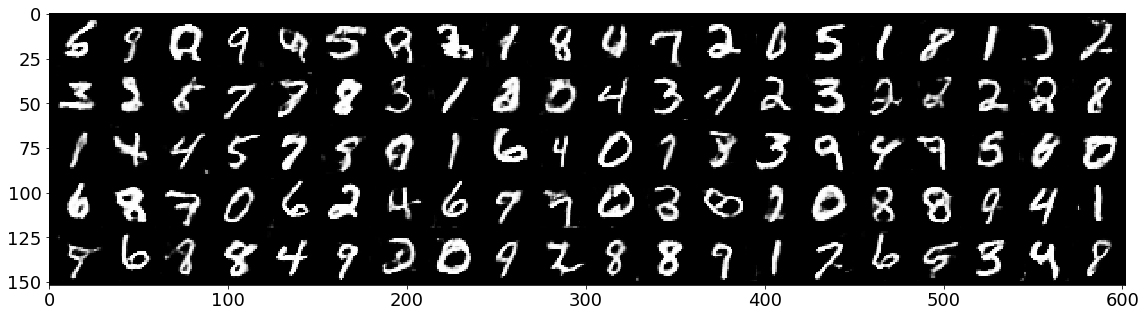

In [13]:
import kmod.plot as plot

# generate images and show
n_gen = 20*5
gen_imgs = gen_q.sample(n_gen)

plt.figure(figsize=(20, 5))
plot.show_torch_imgs(gen_imgs, nrow=20, figsize=(20, 5), normalize=True)

### Load VAE and sample

## Load MNIST Data

In [14]:
# load MNIST data
mnist_folder = glo.data_file('mnist')
mnist_dataset = torchvision.datasets.MNIST(mnist_folder, train=False, 
                        transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ]))

In [15]:
num_sample = 2000
classes = 10
n_sample_per_class = num_sample // classes
len_data = len(mnist_dataset)
input_Z = []
Y = torch.stack([mnist_dataset[i][1] for i in range(len_data)])
X = torch.stack([mnist_dataset[i][0] for i in range(len_data)])
for i in range(classes):
    idx = util.subsample_ind(len(Y[Y==i]), n_sample_per_class)
    input_Z.append(X[Y==i][idx])
#input_Z = [mnist_dataset[i][0] for i in range(num_sample)]
input_Z = torch.cat(input_Z).to(device)


## Sample from generators

In [16]:
def norm(x, loc, scale):
    return (x - loc) / scale


def mnist_norm(x):
    return norm(x, 0.1307, 0.3081)

In [17]:
def trans_gan(x):
    y = norm(x, -1.0, 2.0)
    return mnist_norm(y)


def trans_vae(x):
    return mnist_norm(x).view(-1, 1, 28, 28)

def get_trans(model_type):
    name = model_type.lower()
    if name not in exutil.mnist_model_names:
        raise ValueError('Model name has be one of '
                          '{} and was'.format(key_list, name))
    print('Model: {}'.format(name))
    if 'gan' in name:
        return trans_gan
    elif name == 'vae':
        return mnist_norm

## Optimization settings

In [18]:
J = 30

# gen_p = dcgan.module.forward
# gen_q = vae.decode
gen_p_forward = gen_p.module.forward
gen_q_forward = gen_q.module.forward
trans_p = get_trans(model_type_p)
trans_q = get_trans(model_type_q)
featurizer = extractor_cls

reg = 1e-4 
lam_z = 1e-5
lam_gw = 1e-4
gwidth_lb = None
gwidth_ub = None
Zp_lb= -(4.**2)
Zp_ub= 1.**2
Zq_lb= -(4.**2)
Zq_ub= 50.**2

X = featurizer(trans_p(gen_p.sample(num_sample)))
Y = featurizer(trans_q(gen_q.sample(num_sample)))
#Y = featurizer(trans_q(vae_sample(vae, num_sample)))
Z = featurizer(input_Z)

XYZ = np.vstack((X.cpu().data.numpy(), Y.cpu().data.numpy(), Z.cpu().data.numpy()))
med = util.meddistance(XYZ, subsample=1000)
gwidth0 = med
Zp0 = torch.rand([J, gen_p.in_out_shapes[0]]) - 0.5
Zq0 = torch.rand([J, gen_q.in_out_shapes[0]]) - 0.5 

Model: lsgan
Model: dcgan


/nfs/nhome/live/heishirok/anaconda3/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


In [19]:
def reg_z(Zp, Zq):
    eps = 0.  # 1e-10
    log_bar_p = (torch.sum(torch.log(Zp_ub-Zp**2+eps)) 
                 if Zp_ub is not None else 0)
    # log_bar_p = (log_bar_p + torch.sum(torch.log(-Zp_lb+Zp+eps))
                 # if Zp_lb is not None else log_bar_p)
    log_bar_q = (torch.sum(torch.log(Zq_ub-Zq**2+eps)) 
                 if Zq_ub is not None else 0)
    #log_bar_q = (log_bar_q + torch.sum(torch.log(-Zq_lb+Zq+eps))
                 #if Zq_lb is not None else log_bar_q)
    return log_bar_p + log_bar_q

def reg_gw2(gwidth2):
    eps = 0.  # 1e-6
    log_bar_gwidth = (torch.log(gwidth_ub-gwidth2+eps)
                      if gwidth_ub is not None else 0)
    log_bar_gwidth = (log_bar_gwidth + (torch.log(-max(gwidth_lb, 0)+gwidth2+eps))
                      if gwidth_lb is not None else log_bar_gwidth)

    return log_bar_gwidth

## Optimization

In [20]:
dtype = torch.float
gwidth2 = torch.tensor(gwidth0**2, requires_grad=True, device=device)
k = kernel.PTKGauss(gwidth2)
Zp = torch.tensor(Zp0, requires_grad=True, device=device,
        dtype=dtype)
Zq = torch.tensor(Zq0, requires_grad=True, device=device,
        dtype=dtype)

X = torch.tensor(X, requires_grad=False, 
                 device=device, dtype=dtype)
Y = torch.tensor(Y, requires_grad=False,
                 device=device, dtype=dtype)
Z = torch.tensor(Z, requires_grad=False,
                 device=device, dtype=dtype)

# optimizer = optim.LBFGS([gwidth2, Zp, Zq], lr=1e-3, max_iter=20)
# optimizer = optim.SGD([gwidth2, Zp, Zq], lr=1e-3, momentum=0.9, nesterov=True)
optimizer = optim.Adam([k.sigma2, Zp, Zq], lr=1e-3)
# transform = nn.Upsample((model_input_size, model_input_size), mode='bilinear')

num_steps = 2000
log_inter = 10

run = [0]
while run[0] <= num_steps:
    
    def closure():
        optimizer.zero_grad()
        im_p = gen_p_forward(Zp)
        im_q = gen_q_forward(Zq)
        Vp = featurizer(trans_p(im_p)) if trans_p is not None else featurizer(im_p)
        Vq = featurizer(trans_q(im_q)) if trans_q is not None else featurizer(im_q)
        power = -ume_power_criterion(X, Y, Z, Vp, Vq, k, reg)
        obj = power  - lam_z*reg_z(Zp, Zq) - lam_gw*reg_gw2(k.sigma2)
        #obj = -obj
        obj.backward(retain_graph=True)
        run[0] += 1
        if run[0] % log_inter == 0:
            print('run {}'.format(run))
            print(obj, power)
        return obj
    optimizer.step(closure)

/nfs/nhome/live/heishirok/anaconda3/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


run [10]
tensor(-0.2386, grad_fn=<SubBackward>) tensor(-0.0056, grad_fn=<NegBackward>)
run [20]
tensor(-0.2408, grad_fn=<SubBackward>) tensor(-0.0078, grad_fn=<NegBackward>)
run [30]
tensor(-0.2423, grad_fn=<SubBackward>) tensor(-0.0092, grad_fn=<NegBackward>)
run [40]
tensor(-0.2433, grad_fn=<SubBackward>) tensor(-0.0102, grad_fn=<NegBackward>)
run [50]
tensor(-0.2440, grad_fn=<SubBackward>) tensor(-0.0109, grad_fn=<NegBackward>)
run [60]
tensor(-0.2446, grad_fn=<SubBackward>) tensor(-0.0114, grad_fn=<NegBackward>)
run [70]
tensor(-0.2449, grad_fn=<SubBackward>) tensor(-0.0118, grad_fn=<NegBackward>)
run [80]
tensor(-0.2453, grad_fn=<SubBackward>) tensor(-0.0121, grad_fn=<NegBackward>)
run [90]
tensor(-0.2455, grad_fn=<SubBackward>) tensor(-0.0123, grad_fn=<NegBackward>)
run [100]
tensor(-0.2458, grad_fn=<SubBackward>) tensor(-0.0125, grad_fn=<NegBackward>)
run [110]
tensor(-0.2460, grad_fn=<SubBackward>) tensor(-0.0127, grad_fn=<NegBackward>)
run [120]
tensor(-0.2462, grad_fn=<SubBac

run [950]
tensor(-0.2502, grad_fn=<SubBackward>) tensor(-0.0160, grad_fn=<NegBackward>)
run [960]
tensor(-0.2502, grad_fn=<SubBackward>) tensor(-0.0161, grad_fn=<NegBackward>)
run [970]
tensor(-0.2502, grad_fn=<SubBackward>) tensor(-0.0161, grad_fn=<NegBackward>)
run [980]
tensor(-0.2502, grad_fn=<SubBackward>) tensor(-0.0161, grad_fn=<NegBackward>)
run [990]
tensor(-0.2503, grad_fn=<SubBackward>) tensor(-0.0161, grad_fn=<NegBackward>)
run [1000]
tensor(-0.2503, grad_fn=<SubBackward>) tensor(-0.0161, grad_fn=<NegBackward>)
run [1010]
tensor(-0.2503, grad_fn=<SubBackward>) tensor(-0.0162, grad_fn=<NegBackward>)
run [1020]
tensor(-0.2504, grad_fn=<SubBackward>) tensor(-0.0162, grad_fn=<NegBackward>)
run [1030]
tensor(-0.2504, grad_fn=<SubBackward>) tensor(-0.0162, grad_fn=<NegBackward>)
run [1040]
tensor(-0.2504, grad_fn=<SubBackward>) tensor(-0.0162, grad_fn=<NegBackward>)
run [1050]
tensor(-0.2504, grad_fn=<SubBackward>) tensor(-0.0162, grad_fn=<NegBackward>)
run [1060]
tensor(-0.2504,

run [1880]
tensor(-0.2509, grad_fn=<SubBackward>) tensor(-0.0167, grad_fn=<NegBackward>)
run [1890]
tensor(-0.2509, grad_fn=<SubBackward>) tensor(-0.0167, grad_fn=<NegBackward>)
run [1900]
tensor(-0.2509, grad_fn=<SubBackward>) tensor(-0.0167, grad_fn=<NegBackward>)
run [1910]
tensor(-0.2509, grad_fn=<SubBackward>) tensor(-0.0167, grad_fn=<NegBackward>)
run [1920]
tensor(-0.2509, grad_fn=<SubBackward>) tensor(-0.0167, grad_fn=<NegBackward>)
run [1930]
tensor(-0.2509, grad_fn=<SubBackward>) tensor(-0.0167, grad_fn=<NegBackward>)
run [1940]
tensor(-0.2509, grad_fn=<SubBackward>) tensor(-0.0167, grad_fn=<NegBackward>)
run [1950]
tensor(-0.2509, grad_fn=<SubBackward>) tensor(-0.0167, grad_fn=<NegBackward>)
run [1960]
tensor(-0.2509, grad_fn=<SubBackward>) tensor(-0.0167, grad_fn=<NegBackward>)
run [1970]
tensor(-0.2509, grad_fn=<SubBackward>) tensor(-0.0167, grad_fn=<NegBackward>)
run [1980]
tensor(-0.2509, grad_fn=<SubBackward>) tensor(-0.0167, grad_fn=<NegBackward>)
run [1990]
tensor(-0.

In [21]:
gen_imgs = gen_p_forward(Zp)
Vp = featurizer(trans_p(gen_imgs))

<Figure size 576x360 with 0 Axes>

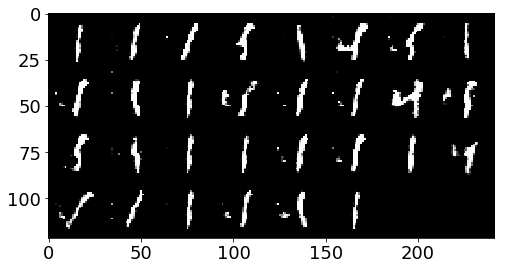

In [22]:
plt.figure(figsize=(8, 5))
plot.show_torch_imgs(gen_imgs.detach(), nrow=8, figsize=(8, 5), normalize=True)

/nfs/nhome/live/heishirok/anaconda3/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


<Figure size 576x360 with 0 Axes>

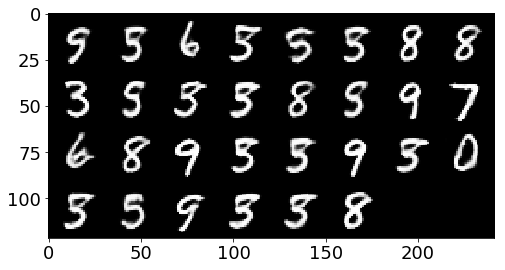

In [23]:
#gen_imgs = vae.decode(Zq).detach().view(-1, 1, 28, 28)
gen_imgs = gen_q_forward(Zq).detach()
Vq = featurizer(trans_q(gen_imgs))
plt.figure(figsize=(8, 5))
plot.show_torch_imgs(gen_imgs, nrow=8, figsize=(8, 5), normalize=True)

In [24]:
print(Zp.max())
print(Zp.min())

tensor(0.5163, grad_fn=<MaxBackward1>)
tensor(-0.5639, grad_fn=<MinBackward1>)


In [25]:
print(Zq.max())
print(Zq.min())

tensor(1.1243, grad_fn=<MaxBackward1>)
tensor(-1.0408, grad_fn=<MinBackward1>)


In [26]:
print(k.sigma2, gwidth0**2)

tensor(577.5184, requires_grad=True) 579.624948052282


## Check the power criterion value at each location

In [27]:
from kmod import mctest 
from kgof import kernel as kgof_kernel
V = torch.cat([Vp, Vq]).cpu().data.numpy()
for j in range(J):
    V = Vq[j].cpu().data.numpy().reshape([1, -1])
    kg = kgof_kernel.KGauss(gwidth2.item())
    datap = kmod.data.Data(X.cpu().data.numpy())
    dataq = kmod.data.Data(Y.cpu().data.numpy())
    datar = kmod.data.Data(Z.cpu().data.numpy())
    sc_ume = mctest.SC_UME(datap, dataq, kg, kg, V, V)
    print(j, sc_ume.compute_stat(datar))

0 0.0021229307524354623
1 0.0045556070052892046
2 0.001532596845610574
3 0.004105348172722633
4 0.0046270789713690665
5 0.004026369725938628
6 0.0016256184687920025
7 0.001185243055615036
8 0.00015319495991649807
9 0.003393259331762002
10 0.0038240446789392607
11 0.004248037472336942
12 0.0012308617352363353
13 0.003485937546779899
14 -0.0001699894624170141
15 -0.005057466280090562
16 0.0007717431804569767
17 0.001107849410491492
18 3.0436481812658948e-05
19 0.004471927774496253
20 0.004566518849966231
21 0.0001460365695229481
22 0.0039430188063819364
23 0.00035635566021083775
24 0.0038910238986482864
25 0.004859663660266848
26 0.001044925379586677
27 0.004409247962350471
28 0.0038526563119467526
29 0.0013383285591506491
